In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 7. Cell Counting

Trains a fully connected neural network to identify handwritten digits using MNIST dataset.

## 1. Setup

Imports and defines the objects needed for this example.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import skimage
import scipy

from deeptrack.features import SampleToMasks, Lambda, LoadImage, ConditionalSetFeature
from deeptrack.optics import Fluorescence
from deeptrack.scatterers import Ellipsoid
from deeptrack.noises import Poisson, Offset
from deeptrack.augmentations import ElasticTransformation, Pad, FlipLR, FlipUD, FlipDiagonal, PreLoad
from deeptrack.math import NormalizeMinMax, Clip
from deeptrack.models import UNet
from deeptrack.generators import Generator

Using TensorFlow backend.


## 2. Defining the dataset

### 2.1 Generating cell-like scatterers.

Cells are represented as random ellipses with some elastic transformation applied to them

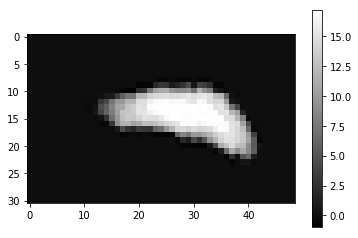

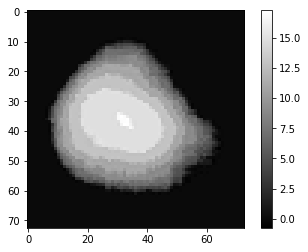

In [5]:
optics = Fluorescence(
    resolution=1e-6,
    magnification=6,
    wavelength=400e-9,
    NA=1.1,
    output_region=(0, 0, 48, 48)
)


ellipse = Ellipsoid(
    radius=lambda: np.random.rand(3) * [5e-6, 4e-6, 0.5e-6] + [0.5e-6, 0.5e-6, 1e-6],
    position_unit="pixel",
    intensity=lambda: 0.5 + np.random.rand(),
    voxel_size=lambda: optics.voxel_size,
    position=lambda: 20 + np.random.rand(2) * (np.array(optics.output_region[2:3]) - 40),
    rotation=lambda: np.random.rand() * 2 * np.pi
)

ellipses = ellipse ** (lambda: 2)

padded_ellipses = Pad(ellipses, px=(10, 10, 10, 10), keep_size=False)

cells = ElasticTransformation(padded_ellipses, alpha=100, sigma=10, keep_size=False)

list_of_cells = cells.update().resolve()
for image_of_cell in list_of_cells:
    plt.imshow(np.sum(image_of_cell, axis=-1), cmap="gray")
    plt.colorbar()
    plt.show()

In [37]:
noisy_cells = cells + Poisson(snr=lambda: 1.5)

kernel = np.ones((3, 3, 3)) / 27

smoothing = Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, kernel) * (image > 0)) 
noisy_cells += smoothing ** 3

Define a mask that represents the desired network output.

In [38]:
def get_mask(image):
    projected_image = np.sum(image, axis=-1)
    mask = projected_image > 0.5
    X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    area = np.sum(mask)
    x_center = np.sum(mask * Y) / area
    y_center = np.sum(mask * X) / area
    output = np.zeros_like(image)
    output[int(x_center), int(y_center)] = 1
    return output

synthetic_mask = cells + SampleToMasks(
    lambda: get_mask, 
    number_of_masks=1,
    output_region=lambda: optics.output_region, 
    merge_method="add"
)

def norm(vmin=0,vmax=1,phi=0):
    def inner(image):
        im=image[:,:,0]-1+1j*image[:,:,1]
        image=np.zeros(image.shape)
        ma=np.amax(np.abs(im))
        im/=ma
        im*=(vmin+np.random.rand()*(vmax-vmin))*np.exp(1j*phi)
        image[:,:,0]=np.real(im)
        image[:,:,1]=np.imag(im)
        return image
normalization = Lambda(
    norm,
    vmin=0.1,
    vmax=1,
    phi=lambda:2*np.pi*np.random.rand()
)

(33, 35, 17)


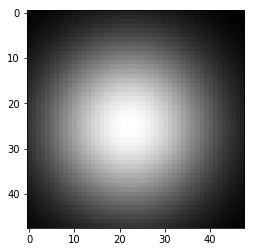

In [39]:
from skimage.filters import gaussian 

NORM_FACTOR = 1000

def gaussian_filter(width):
    def apply_guassian_filter(image):
        image = np.pad(image, [(1, 1), (1, 1), (0, 0)])
        image = gaussian(image, width, truncate=2.5) * NORM_FACTOR
        image = image[1:-1, 1:-1]
        return image
    return apply_guassian_filter

make_gaussian = Lambda(function=gaussian_filter, width=13)

blurred_synthetic_mask = synthetic_mask + make_gaussian

mask = blurred_synthetic_mask.update().resolve()
plt.imshow(mask[..., 0], cmap="gray")
plt.show()

Image the cells through an optical device. To make the cells less homgenous, we add a poisson noise to each cell.

In [40]:

imaged_cells = optics(noisy_cells)

image_noise = Offset(offset=lambda: 1.5 + np.random.rand()) + Poisson(snr=lambda: 40 + np.random.rand() * 20)
saturation = Clip(0, lambda: 12)
normalization = NormalizeMinMax() + Clip(0.05, 1)

noisy_image = imaged_cells + image_noise + saturation + normalization

synthetic_dataset = FlipLR(FlipUD(FlipDiagonal([noisy_image, blurred_synthetic_mask]))) 

### 2.3 Defining the validation set

In [41]:
DATASET_PATH = "./datasets/CellCounting/"
METADATA_PATH = os.path.join("./datasets/CellCounting/", "metadata", "validation.txt")

filenames = open(METADATA_PATH, "r").read().split("\n")[:-1]
filenames = [filename[:-4] for filename in filenames]

filename_iterator = itertools.cycle(filenames)

validation_image = LoadImage(
    filename=filename_iterator,
    path=lambda filename: os.path.join(DATASET_PATH, "images", filename) + ".tif"
)

validation_mask = LoadImage(
    filename=lambda: validation_image.filename,
    path=lambda filename: os.path.join(DATASET_PATH, "masks", filename) + ".png"
)

In [42]:
def decode_mask(validation_mask):
    integer_labels = skimage.morphology.label(validation_mask)[:, :, 0:1]
    props = skimage.measure.regionprops(integer_labels)

    output = np.zeros(integer_labels.shape)    
    for prop in props:
        centroid = prop["Centroid"]
        output[int(centroid[0]), int(centroid[1]), 0] = 1
    
    return output

png_to_mask = Lambda(lambda: decode_mask)

In [43]:
blurred_validation_mask = validation_mask + png_to_mask + make_gaussian
normalized_validation_image = validation_image + normalization

validation_dataset = PreLoad([normalized_validation_image, blurred_validation_mask], load_size=1, updates_per_reload=1) 

We define a feature for loading the mask.

In [44]:
# Load labels from storage
def get_image(image):
    I = image[0]
    if I.ndim == 2:
        I = np.expand_dims(I, axis=-1)
    return I[:(I.shape[0]//16)*16, :(I.shape[1]//16)*16]

def get_label(image):
    I = image[1]
    return I[:(I.shape[0]//16)*16, :(I.shape[1]//16)*16]

### 2.4 Visualizing the dataset

To ensure the data and the labels match up we plot 8 images print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`. Since we flattened the images we need to reshape the images again to visualize them.

In [48]:
cells = []
for _ in range(100):
    for _ in range(8):
        synthetic_dataset.update()
    image, mask = synthetic_dataset.resolve()
#     plt.figure(figsize=(15, 5))
#     plt.subplot(121)
#     plt.imshow(image[:, :, 0], cmap="gray")
#     plt.colorbar()
#     plt.subplot(122)
#     plt.imshow(mask[:, :, 0], cmap="gray")
#     plt.show()
    
    cells.append(image)
    
import scipy.io as io

io.savemat("../../figures/cellcounting_cells.mat", {"cells":np.array(cells)})

(37, 27, 17)
(13, 33, 13)
(51, 35, 15)
(39, 47, 15)
(29, 19, 15)
(21, 23, 15)
(17, 39, 15)
(49, 59, 13)
(31, 31, 13)
(13, 19, 17)
(39, 19, 15)
(47, 43, 13)
(21, 63, 15)
(51, 45, 17)
(37, 33, 17)
(43, 31, 13)
(17, 25, 15)
(25, 35, 17)
(15, 33, 17)
(33, 37, 15)
(37, 31, 13)
(15, 11, 17)
(33, 43, 13)
(31, 37, 15)
(29, 31, 15)
(53, 11, 13)
(45, 41, 17)
(39, 35, 17)
(51, 53, 17)
(33, 23, 13)
(47, 47, 15)
(39, 11, 17)
(47, 27, 13)
(37, 25, 15)
(13, 17, 13)
(25, 7, 13)
(51, 51, 15)
(25, 45, 15)
(57, 47, 13)
(19, 19, 13)
(35, 33, 17)
(35, 45, 13)
(35, 31, 15)
(23, 23, 15)
(25, 41, 15)
(27, 29, 13)
(15, 13, 15)
(11, 31, 13)
(55, 45, 15)
(37, 39, 17)
(41, 29, 17)
(33, 55, 17)
(49, 35, 13)
(39, 41, 15)
(17, 11, 17)
(29, 27, 17)
(27, 25, 13)
(35, 33, 13)
(49, 55, 15)
(61, 43, 17)
(43, 45, 17)
(27, 23, 13)
(35, 45, 13)
(35, 23, 13)
(49, 35, 17)
(33, 35, 13)
(9, 37, 13)
(61, 15, 15)
(15, 15, 15)
(39, 35, 15)
(19, 35, 13)
(25, 49, 17)
(41, 41, 15)
(33, 37, 15)
(17, 19, 15)
(35, 35, 15)
(49, 9, 15)
(1

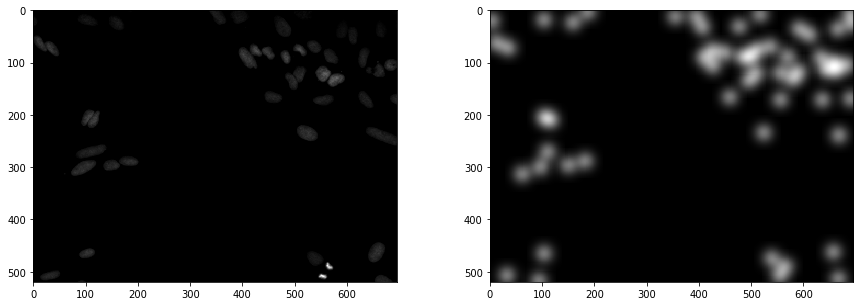

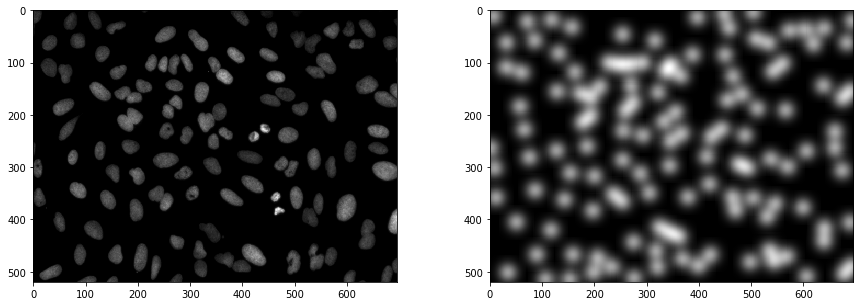

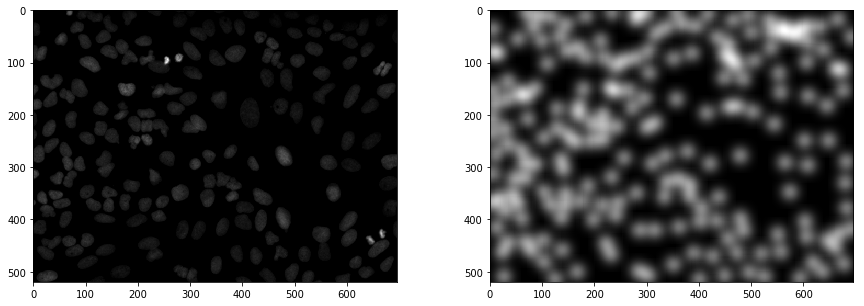

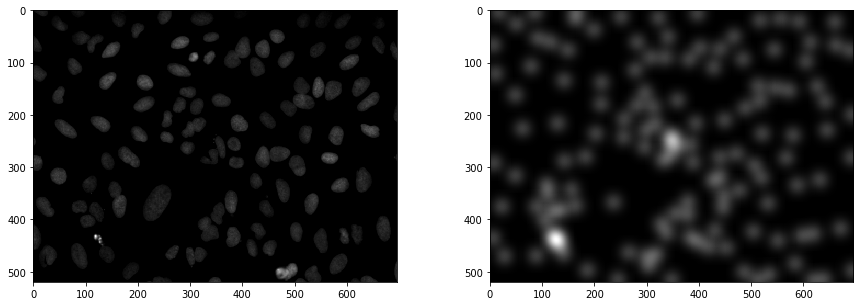

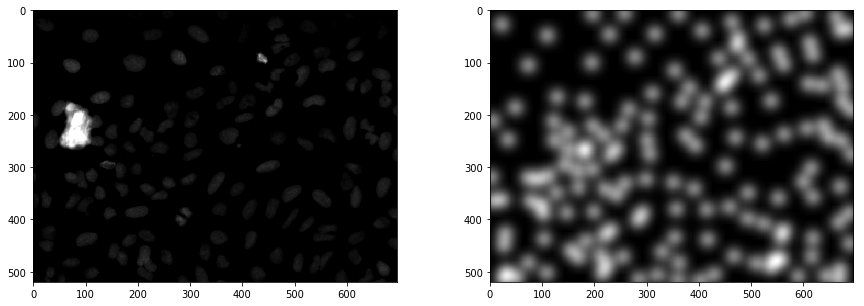

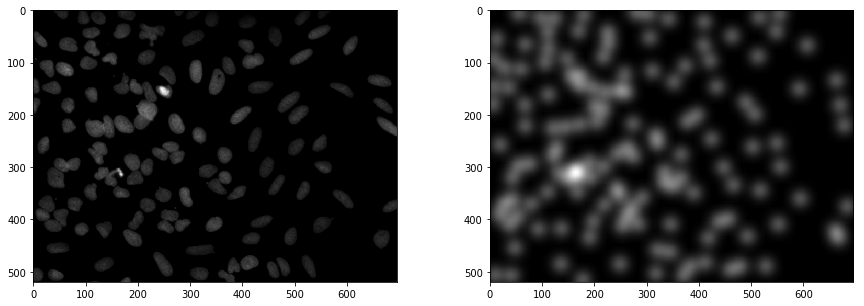

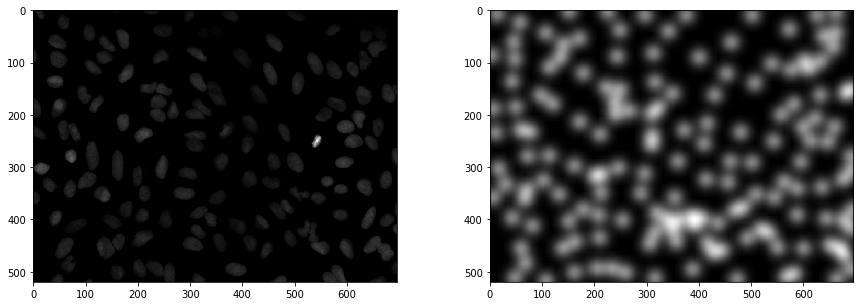

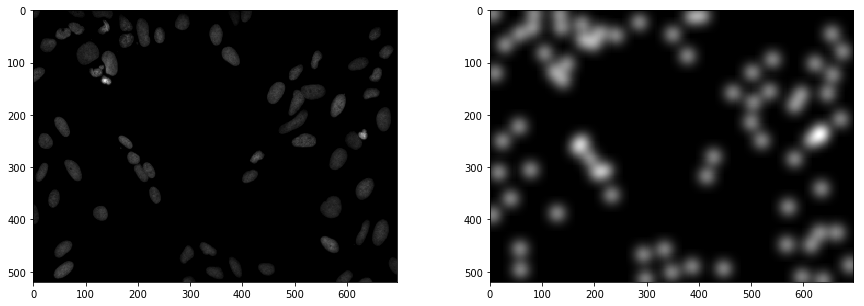

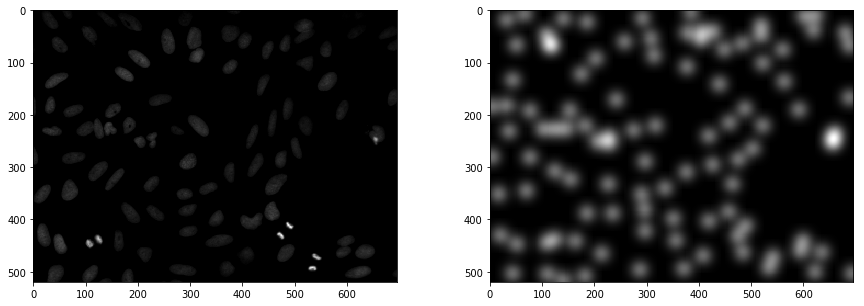

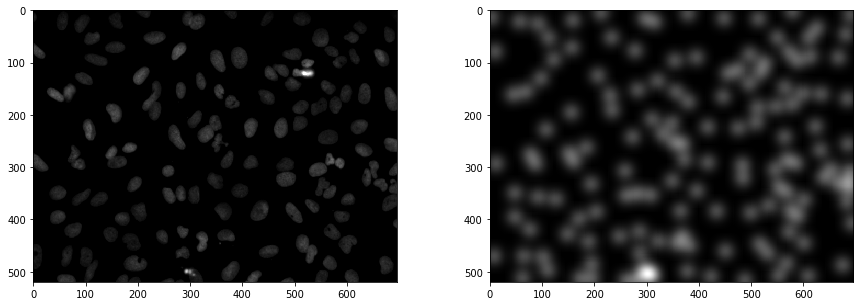

In [18]:
for _ in range(10):
    validation_dataset.update()
    image, mask = validation_dataset.resolve()
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.subplot(122)
    plt.imshow(mask[:, :, 0], cmap="gray")
    plt.show()

## 3. Defining the network

The network used is a fully connected neural network. Here we define the network architecture, loss function and the optimizer.

In [23]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.losses as losses

eps = 1e-6

loss_weights = [3, 1]

def mae(T, P):
    return K.mean(K.abs(T - P)) * loss_weights[0]

def count_error(T, P):
    return K.mean(K.abs(K.mean(T - P, axis=(1, 2)))) * loss_weights[1]


def total_loss(T, P):
    return mae(T, P) + count_error(T, P)


model = UNet(
    input_shape=(None, None, 1),
    number_of_outputs=1,
    steps_per_pooling=2,
    output_activation="relu",
    loss=total_loss,
    metrics=[mae, count_error],
    optimizer="adam"
)

model.load_weights("CellCounting.h5")
    
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, None, None, 1 160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, None, None, 1 2320        conv2d_42[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, None, None, 1 0           conv2d_43[0][0]                  
____________________________________________________________________________________________

## 4. Training the network

The network is trained for 100 epochs using standard Keras syntax.

By passing the argument `validation=True` to `resolve` we toggle `ConditionalSetProperty` to load from the validation files instead.

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

generator = Generator().generate(synthetic_dataset, get_label, get_image, batch_size=32)

validation_set = [validation_dataset.update().resolve() for _ in range(len(filenames))]
validation_data = [get_image(v_tuple) for v_tuple in validation_set]
validation_labels = [get_label(v_tuple) for v_tuple in validation_set]


h = model.fit(
    generator,
    steps_per_epoch=10,
    epochs=1000,
    workers=0,
    validation_data=(
        np.array(validation_data),
        np.array(validation_labels)
    ), 
    callbacks = [
        EarlyStopping("val_count_error", patience=100, restore_best_weights=True)
    ] 
)

Epoch 1/1000
10/10 [==============================] - 37s 4s/step - loss: 0.2124 - mae: 0.1737 - count_error: 0.0386 - val_loss: 1.1032 - val_mae: 0.8348 - val_count_error: 0.2756
Epoch 2/1000
10/10 [==============================] - 38s 4s/step - loss: 0.3060 - mae: 0.2521 - count_error: 0.0540 - val_loss: 0.8801 - val_mae: 0.6760 - val_count_error: 0.2151
Epoch 3/1000
10/10 [==============================] - 36s 4s/step - loss: 0.2136 - mae: 0.1803 - count_error: 0.0333 - val_loss: 0.7467 - val_mae: 0.5842 - val_count_error: 0.1735
Epoch 4/1000
10/10 [==============================] - 40s 4s/step - loss: 0.2672 - mae: 0.2235 - count_error: 0.0437 - val_loss: 0.8211 - val_mae: 0.6333 - val_count_error: 0.1908
Epoch 5/1000
10/10 [==============================] - 38s 4s/step - loss: 0.2665 - mae: 0.2191 - count_error: 0.0474 - val_loss: 0.6894 - val_mae: 0.5409 - val_count_error: 0.1576
Epoch 6/1000
10/10 [==============================] - 41s 4s/step - loss: 0.3520 - mae: 0.2969 - cou

10/10 [==============================] - 37s 4s/step - loss: 0.1076 - mae: 0.0955 - count_error: 0.0121 - val_loss: 0.2713 - val_mae: 0.2267 - val_count_error: 0.0465
Epoch 91/1000
10/10 [==============================] - 39s 4s/step - loss: 0.1076 - mae: 0.0963 - count_error: 0.0113 - val_loss: 0.3123 - val_mae: 0.2479 - val_count_error: 0.0675
Epoch 92/1000
10/10 [==============================] - 39s 4s/step - loss: 0.1069 - mae: 0.0974 - count_error: 0.0095 - val_loss: 0.2601 - val_mae: 0.2220 - val_count_error: 0.0399
Epoch 93/1000
10/10 [==============================] - 39s 4s/step - loss: 0.1366 - mae: 0.1208 - count_error: 0.0158 - val_loss: 0.3135 - val_mae: 0.2495 - val_count_error: 0.0668
Epoch 94/1000
10/10 [==============================] - 37s 4s/step - loss: 0.1036 - mae: 0.0910 - count_error: 0.0125 - val_loss: 0.2380 - val_mae: 0.2129 - val_count_error: 0.0266
Epoch 95/1000
10/10 [==============================] - 42s 4s/step - loss: 0.1276 - mae: 0.1151 - count_error

10/10 [==============================] - 37s 4s/step - loss: 0.1063 - mae: 0.0931 - count_error: 0.0132 - val_loss: 0.2894 - val_mae: 0.2584 - val_count_error: 0.0290
Epoch 181/1000
10/10 [==============================] - 35s 4s/step - loss: 0.0936 - mae: 0.0803 - count_error: 0.0133 - val_loss: 0.2366 - val_mae: 0.2091 - val_count_error: 0.0290
Epoch 182/1000
10/10 [==============================] - 40s 4s/step - loss: 0.1245 - mae: 0.1108 - count_error: 0.0137 - val_loss: 0.2375 - val_mae: 0.2187 - val_count_error: 0.0203
Epoch 183/1000
10/10 [==============================] - 38s 4s/step - loss: 0.1127 - mae: 0.0998 - count_error: 0.0128 - val_loss: 0.2876 - val_mae: 0.2612 - val_count_error: 0.0265
Epoch 184/1000
10/10 [==============================] - 38s 4s/step - loss: 0.0925 - mae: 0.0834 - count_error: 0.0091 - val_loss: 0.2548 - val_mae: 0.2149 - val_count_error: 0.0423
Epoch 185/1000
10/10 [==============================] - 35s 3s/step - loss: 0.0768 - mae: 0.0709 - count_

10/10 [==============================] - 36s 4s/step - loss: 0.0932 - mae: 0.0859 - count_error: 0.0073 - val_loss: 0.2194 - val_mae: 0.2055 - val_count_error: 0.0146
Epoch 271/1000
10/10 [==============================] - 38s 4s/step - loss: 0.0967 - mae: 0.0871 - count_error: 0.0096 - val_loss: 0.2353 - val_mae: 0.1954 - val_count_error: 0.0424
Epoch 272/1000
10/10 [==============================] - 38s 4s/step - loss: 0.0941 - mae: 0.0831 - count_error: 0.0110 - val_loss: 0.2104 - val_mae: 0.1862 - val_count_error: 0.0255
Epoch 273/1000
10/10 [==============================] - 34s 3s/step - loss: 0.0791 - mae: 0.0737 - count_error: 0.0054 - val_loss: 0.2163 - val_mae: 0.1848 - val_count_error: 0.0335
Epoch 274/1000
10/10 [==============================] - 38s 4s/step - loss: 0.0876 - mae: 0.0806 - count_error: 0.0071 - val_loss: 0.2417 - val_mae: 0.2238 - val_count_error: 0.0177
Epoch 275/1000
10/10 [==============================] - 36s 4s/step - loss: 0.0811 - mae: 0.0759 - count_

## 5. Evaluating the training

### 5.1 Loss vs validation
We plot the metrics evaluated on the training data compared to the validation data to spot potential overtraining. 

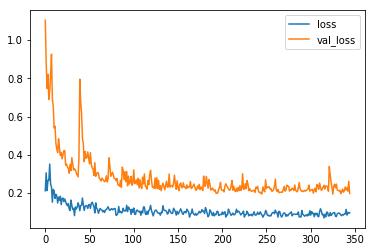

In [30]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show()

### 5.2 Prediction vs actual

We show a few images, the true digit and the predicted digit

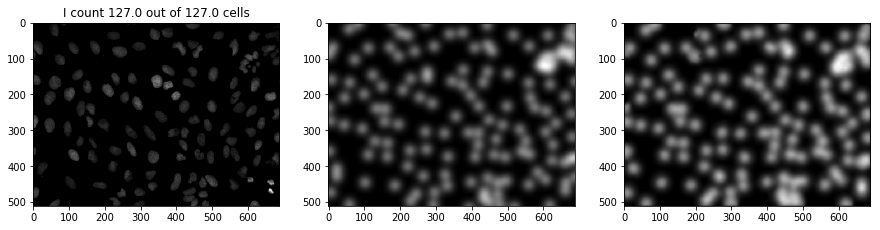

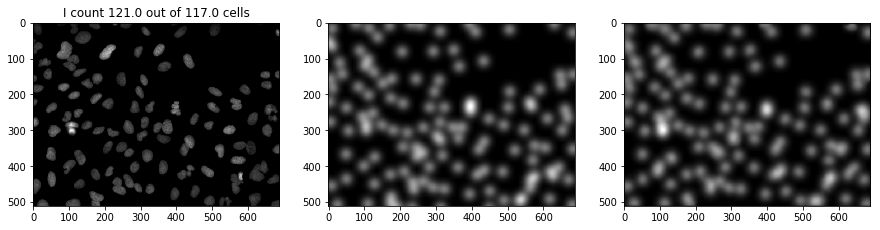

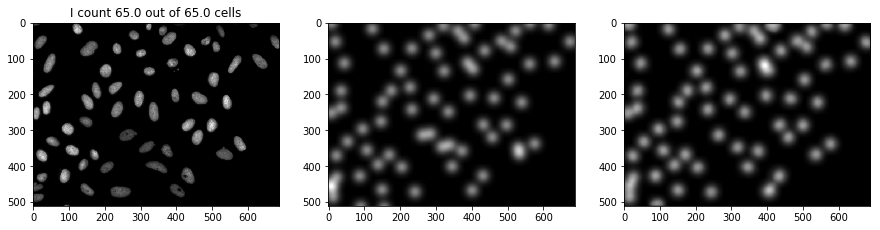

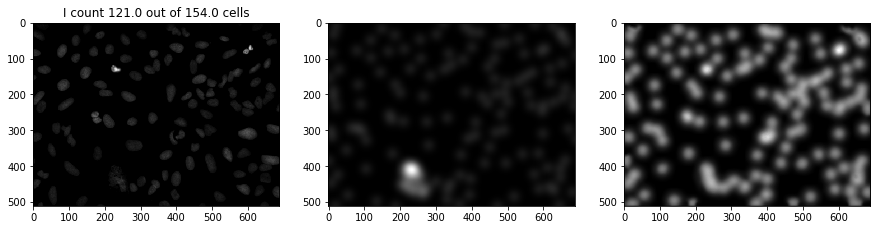

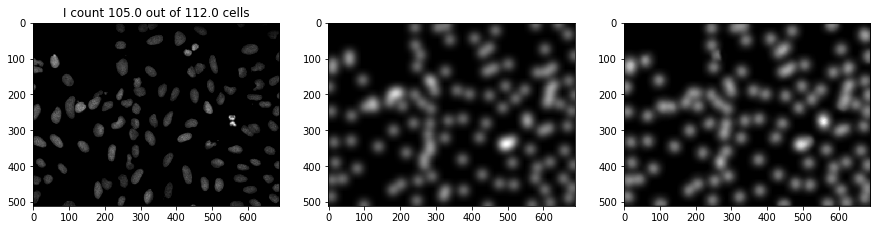

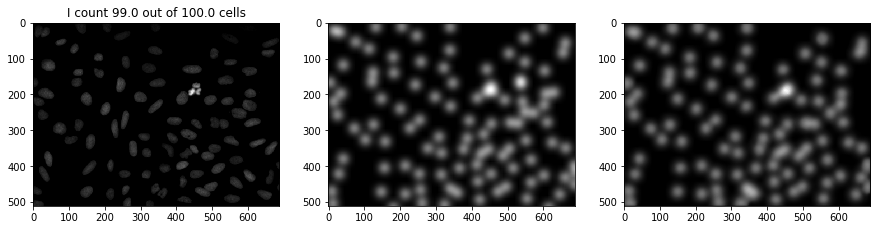

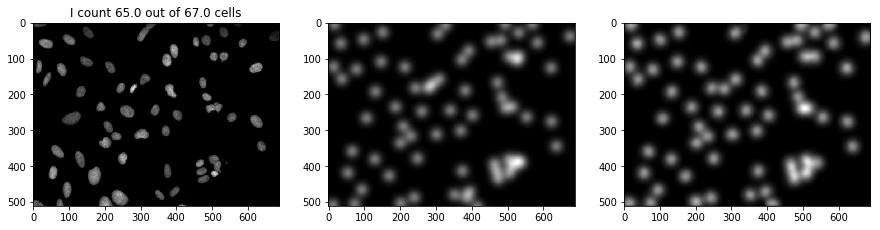

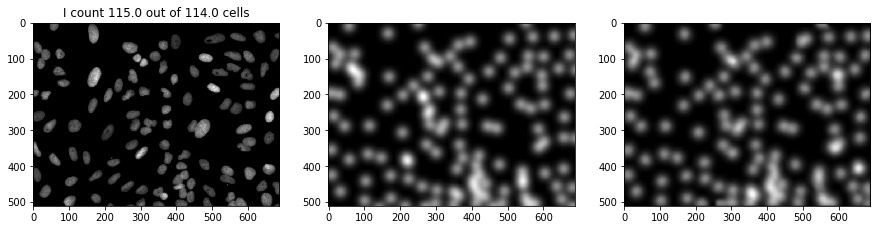

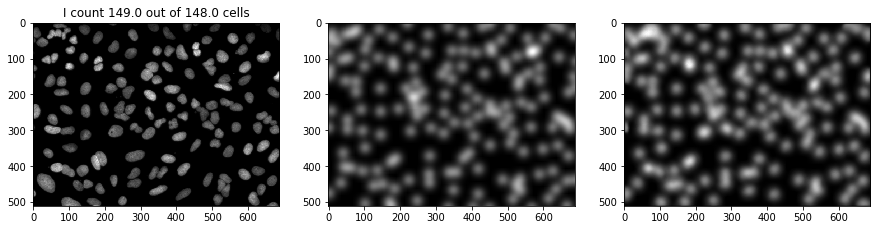

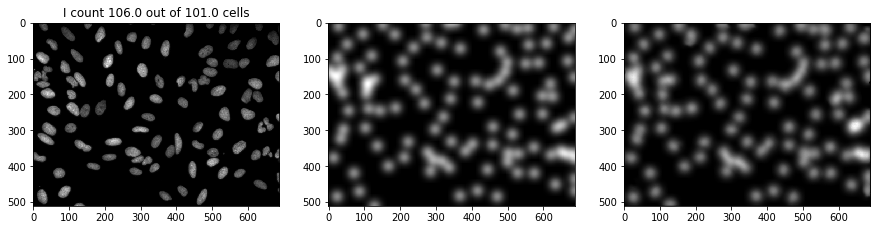

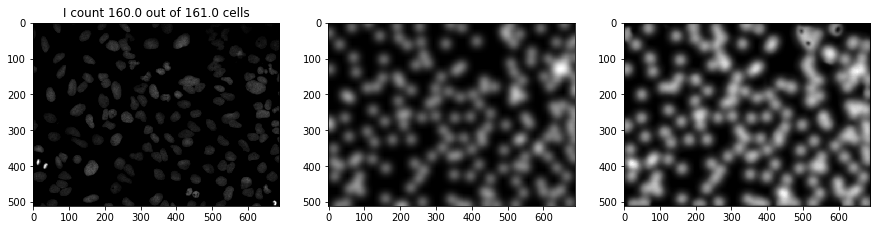

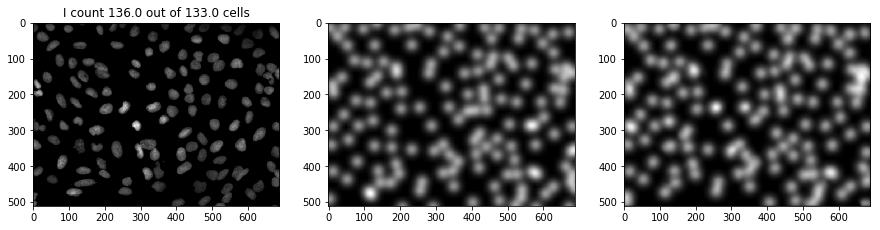

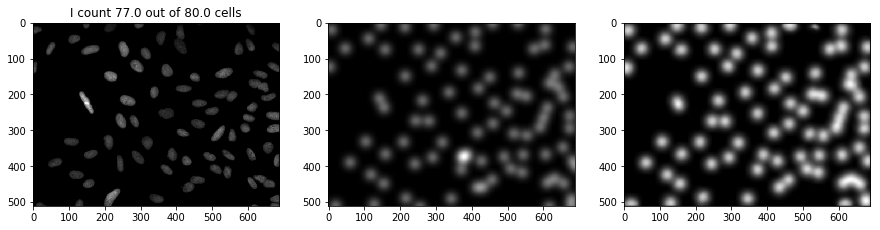

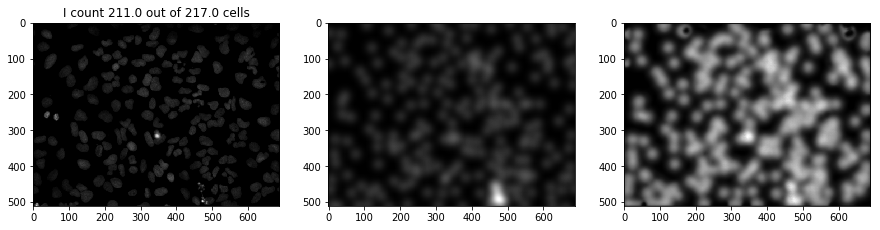

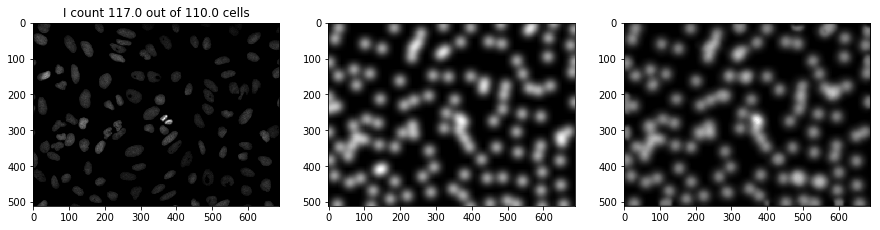

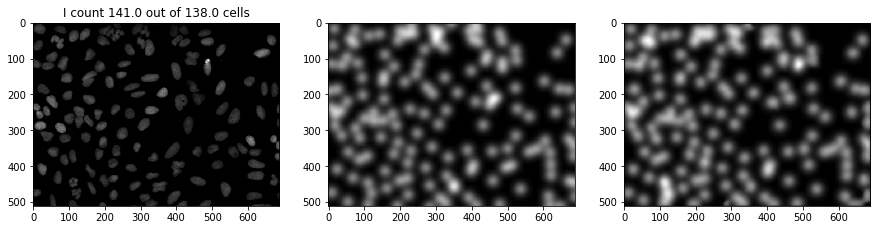

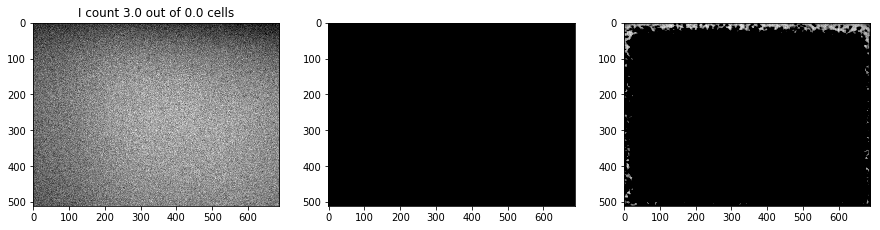

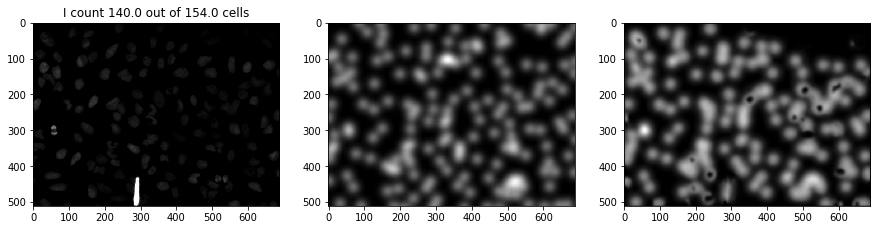

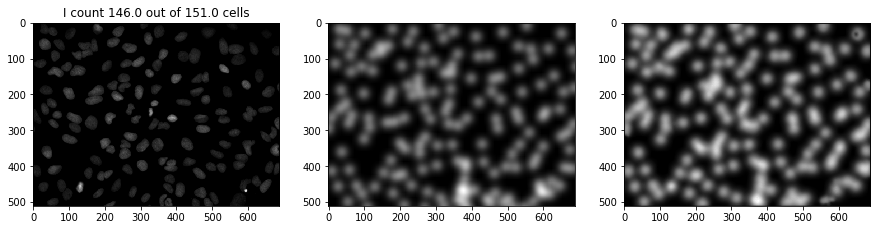

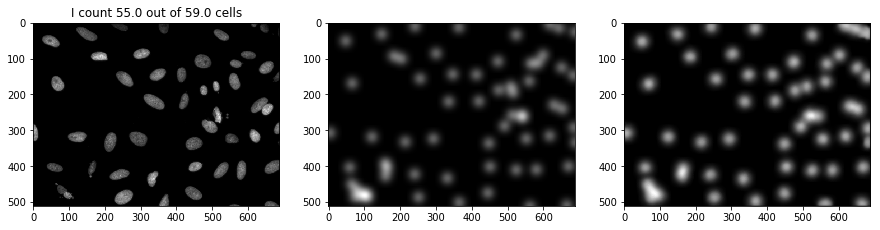

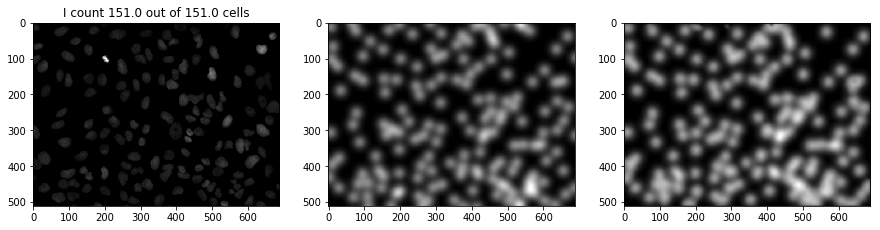

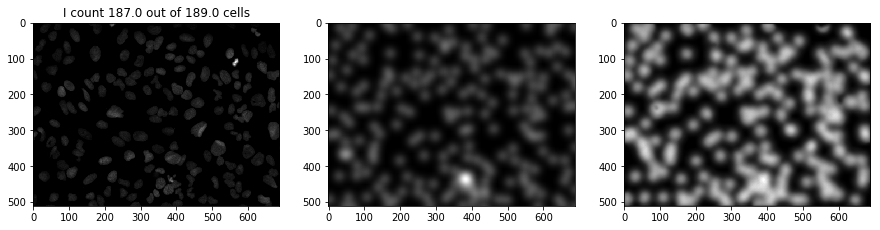

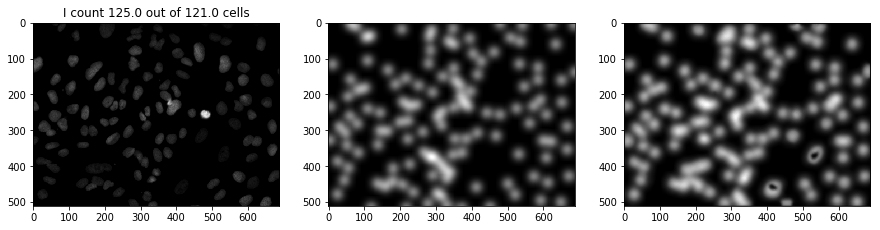

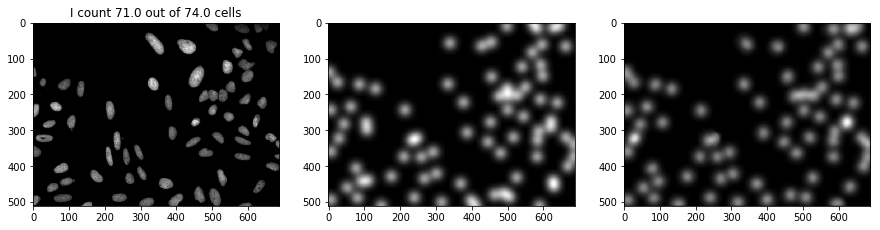

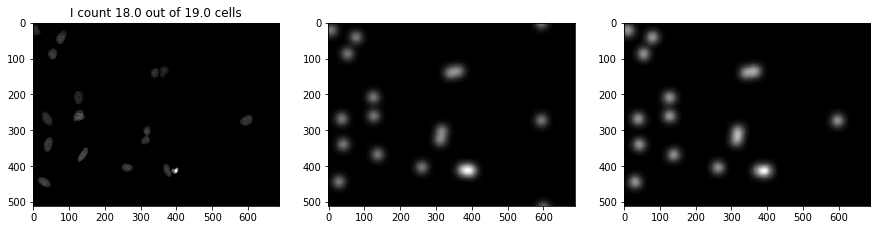

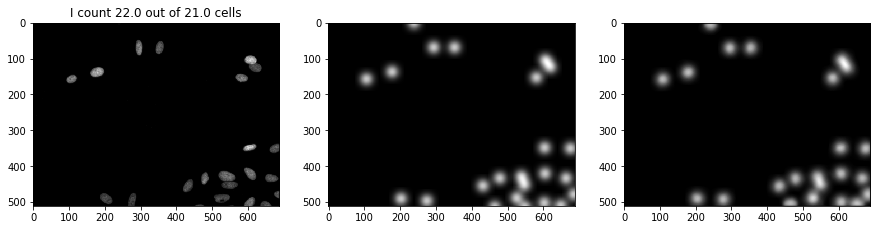

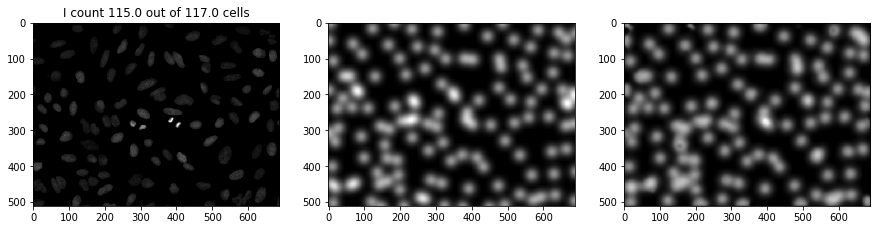

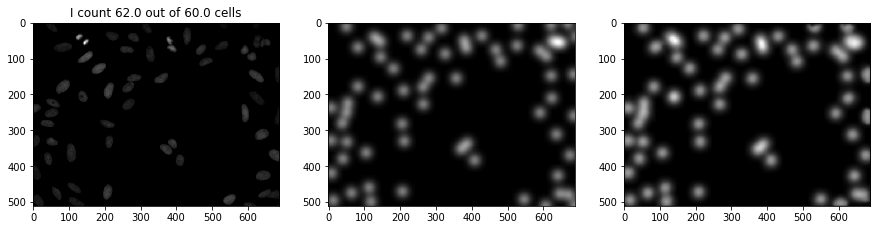

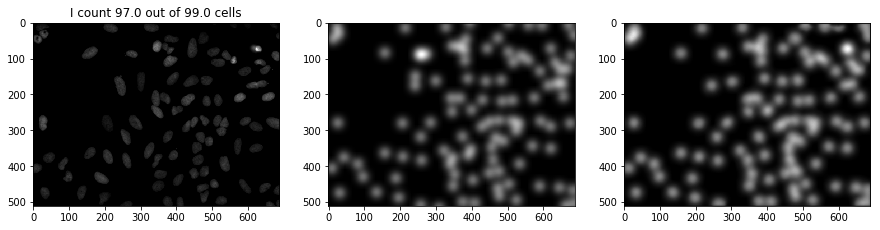

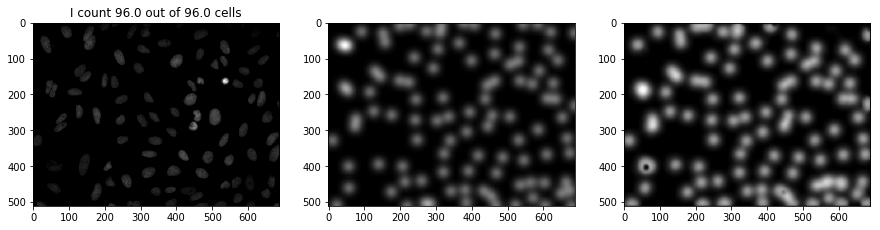

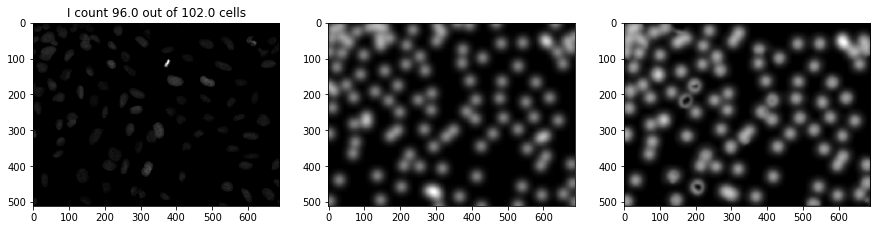

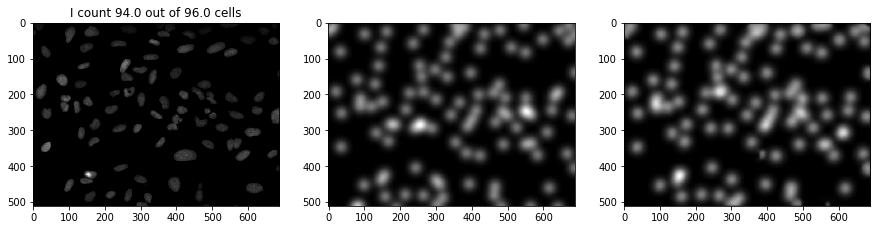

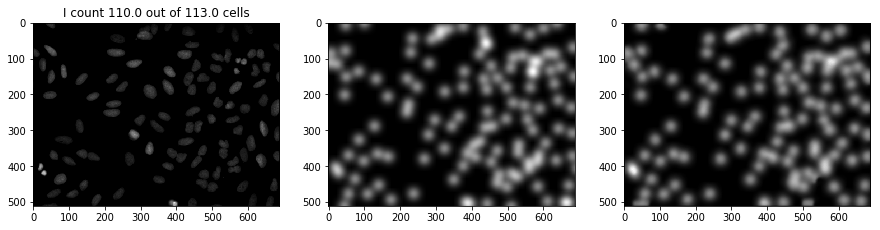

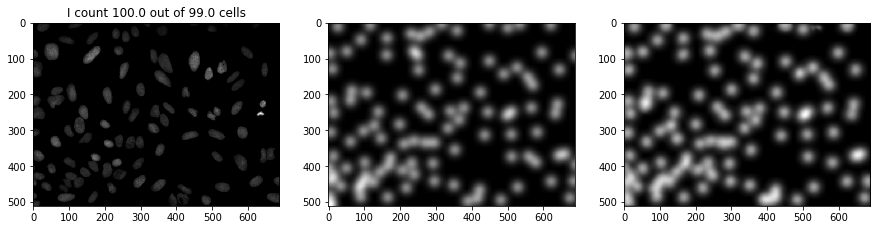

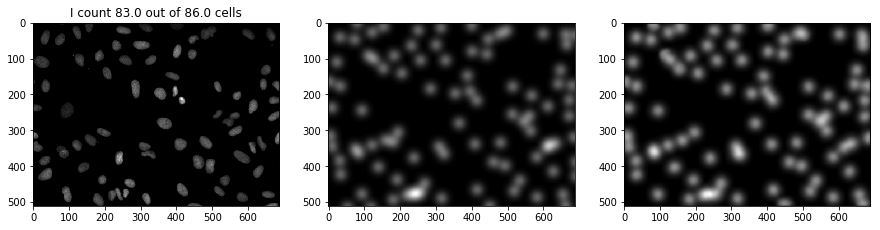

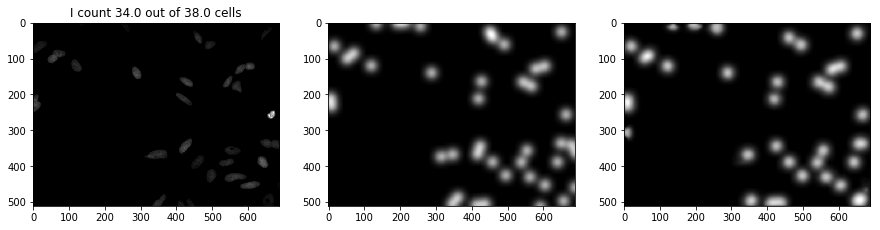

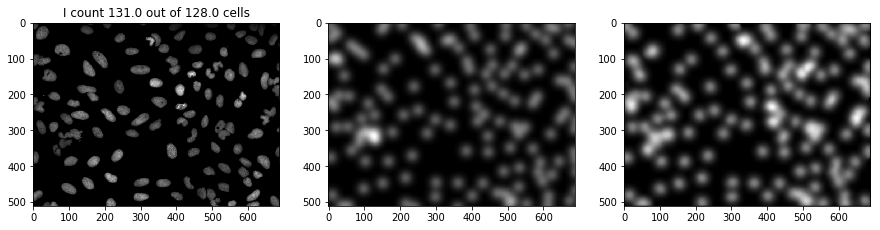

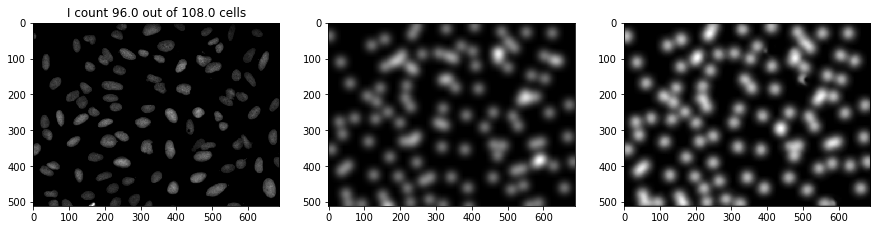

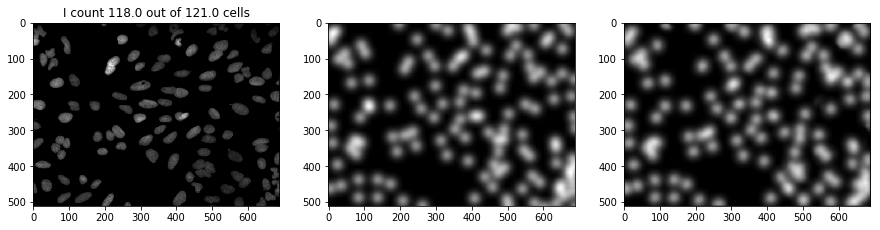

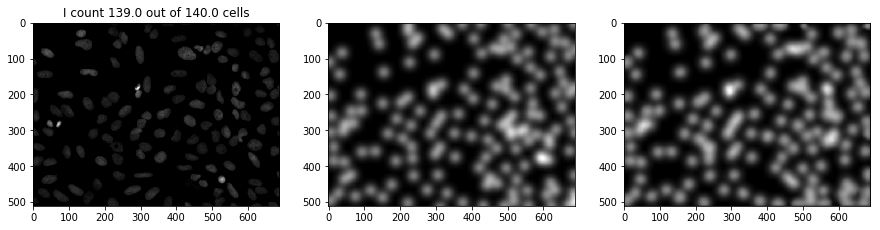

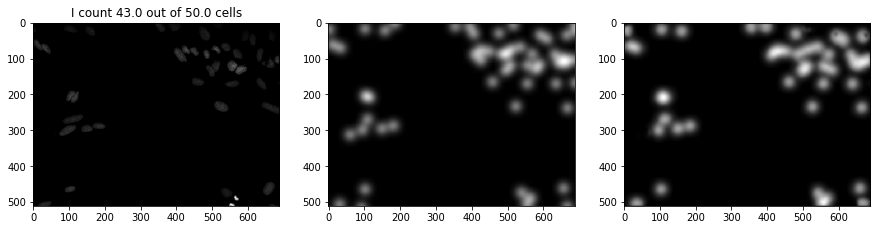

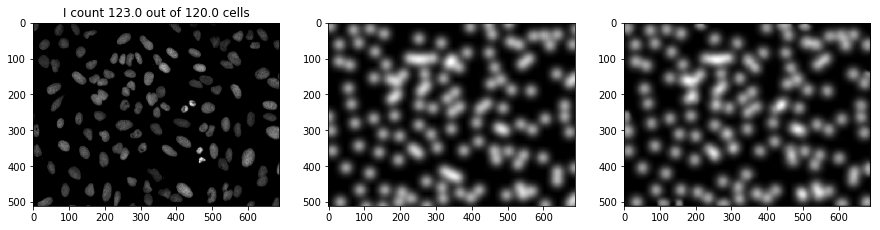

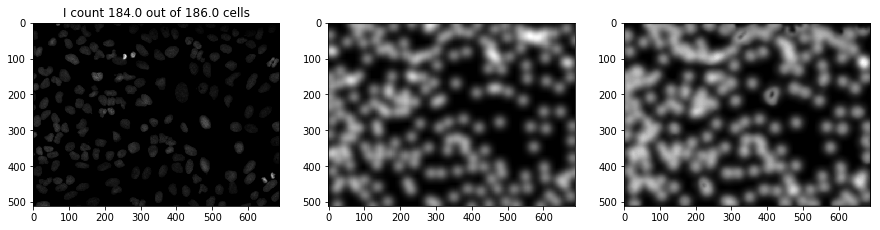

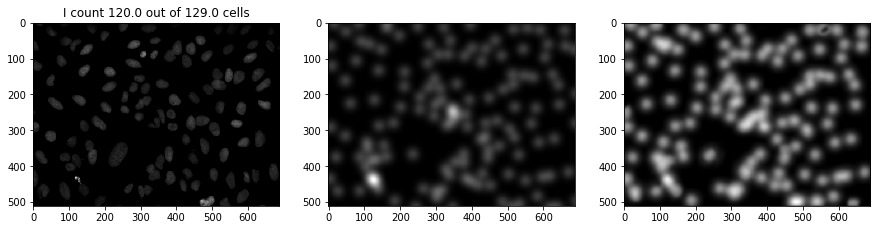

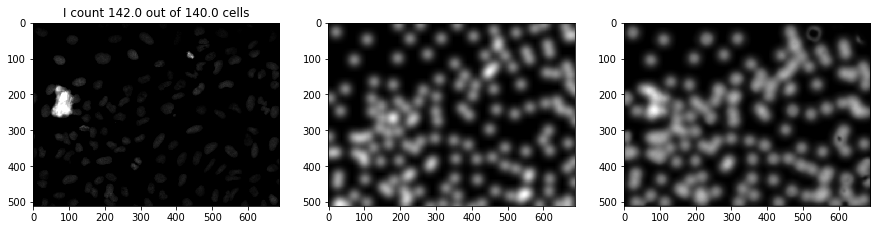

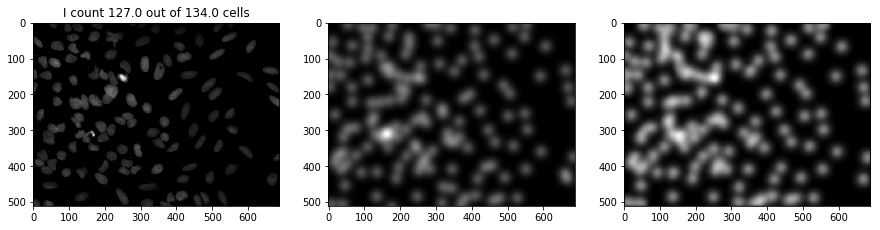

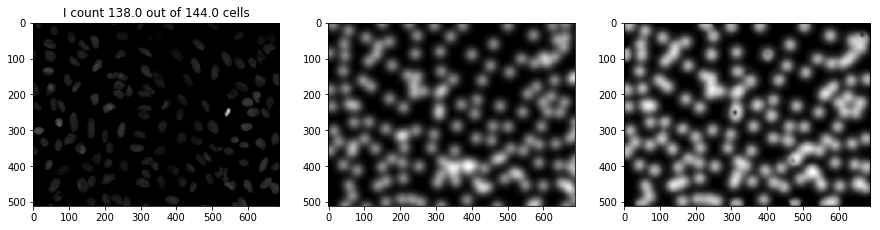

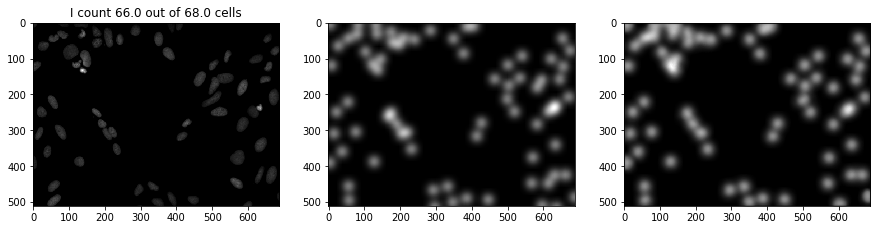

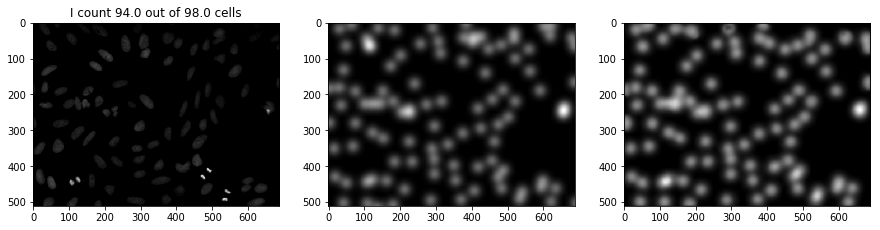

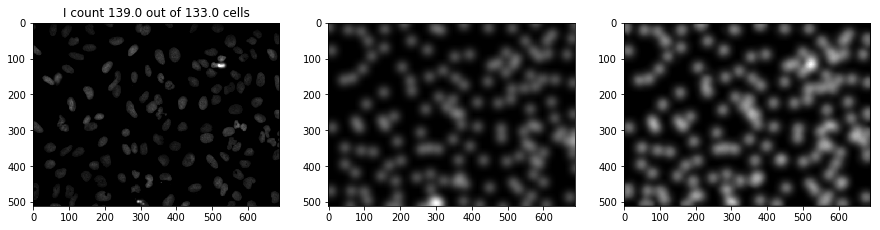

In [31]:
# count_model.load_weights("best_counter.h5")

predictions = model.predict(np.array(validation_data))

for image, mask, prediction in zip(validation_data, validation_labels, predictions):

    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(image[:, :, 0], cmap="gray")
    plt.title("I count {0} out of {1} cells".format(
        np.ceil(np.sum(prediction[:, :, 0]) / NORM_FACTOR),
        np.ceil(np.sum(mask[:, :, 0]) / NORM_FACTOR)
    ))
    
    plt.subplot(132)
    plt.imshow(mask[:, :, 0], cmap="gray")
    
    plt.subplot(133)
    plt.imshow(prediction[:, :, 0], cmap="gray")
    plt.show()
                               